# Motivation 
In this notebook we load the processed data and check if it is correct.
and we create an example of dataloader using pytorch. 
and we create a datamodule for pytorch lightning.
# Summary
- [1. Load data](#1.-Load-data)
- [2. Check data](#2.-Check-data)
- [3. Create dataloader](#3.-Create-dataloader)
- [4. Create datamodule](#4.-Create-datamodule)


# load the data


In [13]:
# let's first load the classical configuration
from config import settings
from pathlib import Path
settings_proc ='SETTINGS1'
settings_simu = 'SETTINGS1'
root= Path(settings.data.path["processed"])
database_path = (root /settings_simu/settings_simu.lower()).with_suffix('.db')

In [14]:
import sqlite3 
conn = sqlite3.connect(database_path)
c=conn.cursor()
c.execute("PRAGMA table_info(processed_data)")
c.fetchall()

[(0, 'id', 'INTEGER', 0, None, 1),
 (1, 'simulation_name', 'TEXT', 0, None, 0),
 (2, 'system_name', 'TEXT', 0, None, 0),
 (3, 'PSD', 'BLOB', 0, None, 0),
 (4, 'resonance_frequency', 'BLOB', 0, None, 0),
 (5, 'anomaly_level', 'REAL', 0, None, 0),
 (6, 'latent_value', 'REAL', 0, None, 0),
 (7, 'RMS', 'REAL', 0, None, 0),
 (8, 'excitation_amplitude', 'REAL', 0, None, 0),
 (9, 'stage', 'TEXT', 0, None, 0)]

In [15]:
import sqlite3 
import numpy as np
conn = sqlite3.connect(database_path)
c=conn.cursor()
c.execute("SELECT * FROM processed_data")
data = c.fetchall()

# now let's isolate the data psd , into an array and each variable into its own array
sim_id = np.array([d[0] for d in data])
sim_name = np.array([d[1] for d in data])
system_name = np.array([d[2] for d in data])
psd = np.array([np.frombuffer(d[3], dtype=np.float64) for d in data])
res_freq = np.array([np.frombuffer(d[4], dtype=np.float64) for d in data])
anomaly_level = np.array([d[5] for d in data])
latent_value = np.array([d[6] for d in data])
rms = np.array([d[7] for d in data])
excitation_amplitude = np.array([d[8] for d in data])
stages = np.array([d[9] for d in data])


In [16]:
# count each stage type 
from collections import Counter
Counter(stages)


Counter({'anomaly': 28000, 'train': 20000, 'test': 4000})

In [17]:
# let's check the shape of the data psd res_freq 
print(f'sim_id shape: {sim_id.shape}')
print(f'sim_name shape: {sim_name.shape}')
print(f'system_name shape: {system_name.shape}')
print(f'psd shape: {psd.shape}')
print(f'res_freq shape: {res_freq.shape}')

sim_id shape: (52000,)
sim_name shape: (52000,)
system_name shape: (52000,)
psd shape: (52000, 513)
res_freq shape: (52000, 8)


In [18]:
# now let's querythe metadata
c.execute("SELECT * FROM metadata")
metadata = c.fetchall()
fs = metadata[0][0]
nperseg = metadata[0][1]
filter_order = metadata[0][2]
lpf = metadata[0][3]
freq = np.frombuffer(metadata[0][4])
SNR = metadata[0][5]
print(f"fs: {fs}, nperseg: {nperseg}, filter_order: {filter_order}, lpf: {lpf}, SNR: {SNR}")


fs: 400.0, nperseg: 1024.0, filter_order: 4.0, lpf: 150.0, SNR: None


# Check data

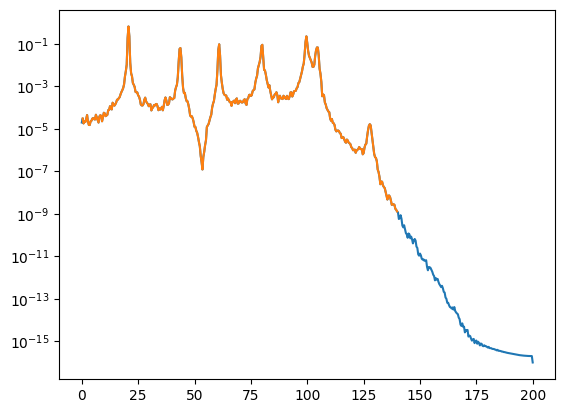

In [19]:
# now let's plot one psd 
import matplotlib.pyplot as plt
from psm.data.processing import cut_psd
plt.plot(freq, psd[0])
plt.yscale('log')
freq_c,psd_c = cut_psd(freq, psd[0], 0, 140)
plt.plot(freq_c, psd_c)

In [21]:
# let's compute the min and max of the psd when anomaly_level = 0
psd_min = np.min(np.log(psd[anomaly_level==0]))
psd_max = np.max(np.log(psd[anomaly_level==0]))
psd_min , psd_max

(-40.43653280354056, 0.48753990699788124)

# dataloader and transformer


In [22]:
import numpy as np
import sqlite3
from typing import Union, Callable
from pathlib import Path


class PSDTransformer:
    def __init__(self, database_path: Union[str, Path], freq, freq_min, freq_max):
        self.database_path = database_path
        self.freq = freq
        self.freq_min = freq_min
        self.freq_max = freq_max
        self.min_psd, self.max_psd = self._calculate_min_max()
        self.transform_psd = self._get_transform_psd()

    @staticmethod
    def _cut_psd(freq, psd, freq_min, freq_max):
        mask = (freq >= freq_min) & (freq <= freq_max)
        return freq[mask], psd[mask]

    def _calculate_min_max(self):
        def pre_transform(psd):
            _, psd = self._cut_psd(self.freq, psd, self.freq_min, self.freq_max)
            psd = np.log(psd)
            return psd

        conn = sqlite3.connect(self.database_path)
        c = conn.cursor()
        c.execute("SELECT PSD FROM processed_data WHERE anomaly_level=0")
        fetched_data = c.fetchall()
        psd = [np.frombuffer(d[0], dtype=np.float64) for d in fetched_data]
        psd = [pre_transform(p) for p in psd]
        return np.min(psd), np.max(psd)

    def _get_transform_psd(self):
        def transform_psd(psd):
            res = self._pre_transform(psd)
            res = (res - self.min_psd) / (self.max_psd - self.min_psd)
            return res

        return transform_psd

    @property
    def label_transform(self):
        return lambda x: int(x.split('_')[-1])

    def _pre_transform(self, psd):
        _, psd = self._cut_psd(self.freq, psd, self.freq_min, self.freq_max)
        psd = np.log(psd)
        return psd
    def dimension_psd(self):
        conn = sqlite3.connect(self.database_path)
        c = conn.cursor()
        c.execute("SELECT PSD FROM processed_data")
        data = np.frombuffer(c.fetchone()[0],dtype=np.float64)
        tr = self._get_transform_psd()
        data = tr(data)
        return len(data)

# Usage:
psd_transformer = PSDTransformer(database_path, freq, freq_min=0, freq_max=150)
transform_psd = psd_transformer.transform_psd
transform_label = psd_transformer.label_transform


In [23]:
psd_transformer.dimension_psd()

385

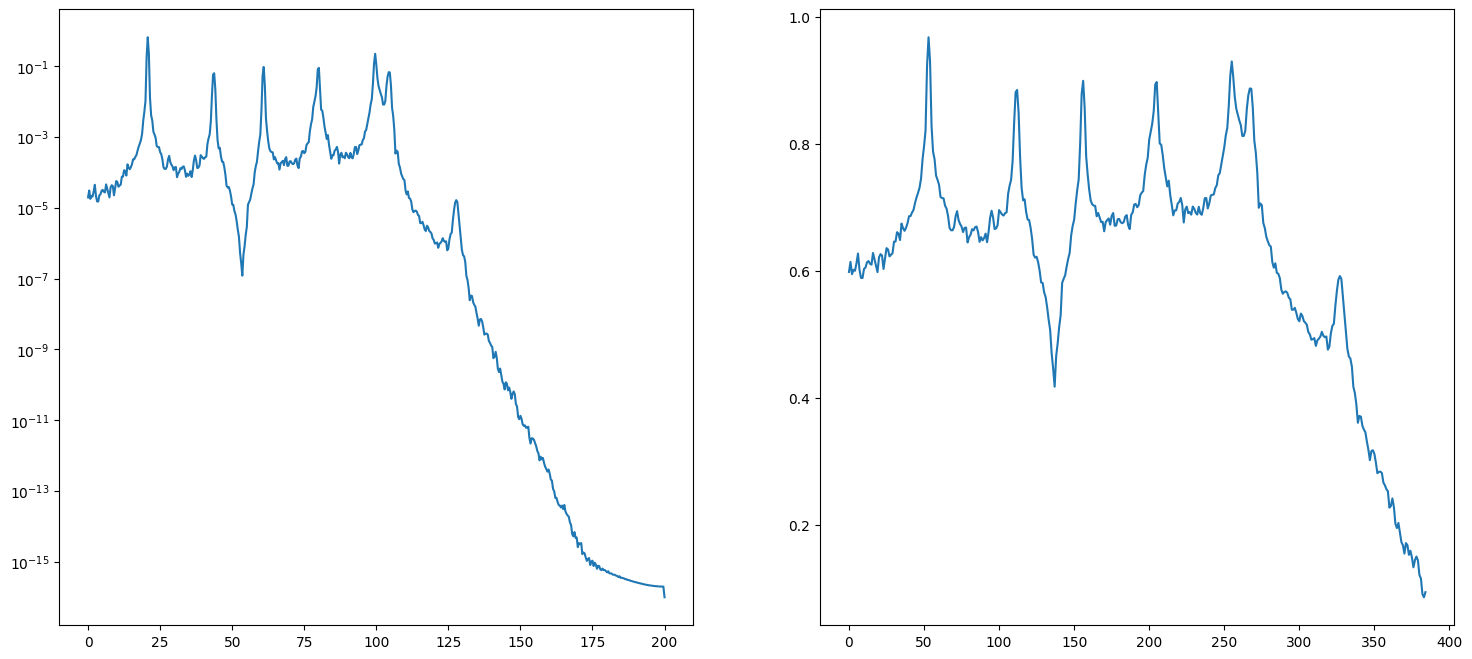

In [24]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(ncols=2,figsize=(18,8))
ax[0].plot(freq,psd[0])
ax[0].set_yscale('log')
ax[1].plot(transform_psd(psd[0]))

In [25]:
import sqlite3
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from typing import Union, List
def build_query(anomaly_level, system_name,stage):
    """ a utile function that prepare the query for you based on the anomaly_level and system_name
    """
    params = []
    clauses = []
    if anomaly_level != '*':
        if isinstance(anomaly_level, list):
            clause = " OR ".join("anomaly_level=?" for _ in anomaly_level)
            params.extend(anomaly_level)
        else:
            clause = "anomaly_level=?"
            params.append(anomaly_level)
        clauses.append(f"({clause})")
    if system_name is not None:
        clauses.append("system_name=?")
        params.append(system_name)
    if stage is not None:
        clauses.append("stage=?")
        params.append(stage)
    query = " AND ".join(clauses) if clauses else "1"  # If no conditions, use "1" to get all data
    return query, tuple(params)


class PSDDataset(Dataset):
    """ a class that generate the dataset, it output the psd and the label
    a possible modification is to add the key as output as well
    usage example:
    dataset = PSDDataset(database_path=database_path, anomaly_level=0,
                     transform_label=transform_label,
                     transform=transform_psd,
                     stage='train/val')
    dataloader = DataLoader(dataset, batch_size=10, shuffle=True)

    for batch in dataloader:
        psd, system_name = batch
        print(system_name)
        plt.plot(psd.T)
        plt.show()
        break   
    """
    def __init__(self, database_path: Union[str, Path], system_name: str = None,
                 anomaly_level: Union[float, List[float], str] = 0.0,
                 transform=None, transform_label=None, preload: bool = False,
                 stage=None):
        
        self.database_path = database_path
        self.system_name = system_name
        self.transform = transform
        self.transform_label = transform_label
        self.preload = preload
        self.stage = stage
        self.conn = sqlite3.connect(self.database_path)
        self.c = self.conn.cursor()

        self.query, self.params = build_query(anomaly_level, system_name,stage)
        self.c.execute(f"SELECT id,stage FROM processed_data WHERE {self.query}", self.params)
        fetched_data = self.c.fetchall()
        self.keys = [d[0] for d in fetched_data]

        if self.preload:
            self.data = self._preload_data()

    def __len__(self):
        return len(self.keys)

    def _preload_data(self):
        # Convert list of keys to a format suitable for SQL IN keyword
        keys_str = ', '.join('?' for _ in self.keys)

        # Execute the query using the keys_str and self.keys
        self.c.execute(f"SELECT PSD, system_name, anomaly_level FROM processed_data WHERE id IN ({keys_str})", self.keys)
        data = self.c.fetchall()
        return data


    def __getitem__(self, index: int):
        if self.preload:
            row = self.data[index]
        else:
            self.c.execute(f"SELECT PSD, system_name,anomaly_level FROM processed_data WHERE id=?", (self.keys[index],))
            row = self.c.fetchone()
        psd = np.frombuffer(row[0], dtype=np.float64)
        system_name = row[1]
        anomaly_level = row[2]
        if self.transform:
            psd = self.transform(psd)
        if self.transform_label:
            system_name = self.transform_label(system_name)
        psd = torch.from_numpy(psd).float()
        
        if self.stage == 'anomaly':
            return psd, system_name, row[2]
        
        return psd, system_name
    

tensor([ 6, 16,  0,  5, 13, 12,  3,  9,  5, 14])


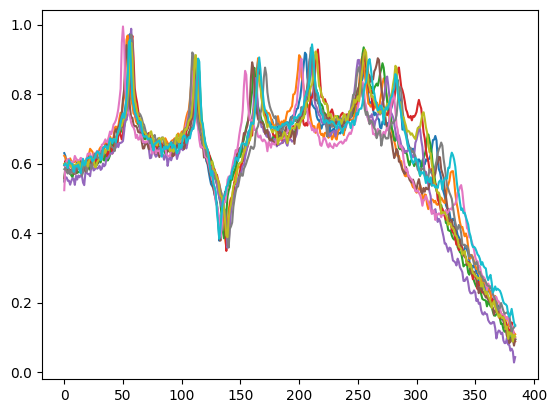

In [26]:
dataset = PSDDataset(database_path=database_path, anomaly_level=0,
                     transform_label=transform_label,
                     transform=transform_psd,
                     stage='train')
dataloader = DataLoader(dataset, batch_size=10, shuffle=True)

for batch in dataloader:
    psd, system_name = batch
    print(system_name)
    plt.plot(psd.T)
    plt.show()
    break


# DataModule for pytorch lightning

In [29]:
import pytorch_lightning as pl  
import functools
from torch.utils.data.dataset import random_split
 
class PSDDataModule(pl.LightningDataModule):
    def __init__(self, database_path, transform=None, transform_label=None, batch_size:int = 64):
        super().__init__()
        self.batch_size = batch_size
        self.dataset = functools.partial(PSDDataset, database_path=database_path,
                                         transform=transform, transform_label=transform_label)

    def setup(self, stage=None): 
        self.full_train_dataset = self.dataset(anomaly_level=0, preload=True, stage='train')
        generator1 = torch.Generator().manual_seed(42)

        self.train_dataset, self.val_dataset = random_split(self.full_train_dataset,[800*20,200*20],
                                                            generator=generator1)
        self.test_dataset = self.dataset(anomaly_level=0, preload=True, stage='test')

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False)
 
        

In [30]:
# Specify your SQLite database path

# Instantiate the PSDDataModule
dm = PSDDataModule(database_path=database_path,transform=transform_psd,
                   transform_label=transform_label, batch_size=64)

# Call the setup method
dm.setup()

# Create dataloaders
train_dl = dm.train_dataloader()
val_dl = dm.val_dataloader()
test_dl = dm.test_dataloader()

# Print some details
print(f"Number of training samples: {len(dm.train_dataset)}")
print(f"Number of validation samples: {len(dm.val_dataset)}")
print(f"Number of test samples: {len(dm.test_dataset)}")

# Get a batch of data
for batch in train_dl:
    data, label = batch
    print(f"Shape of data from train_dl: {data.shape}")
    print(f"Shape of label from train_dl: {label.shape}")
    break


Number of training samples: 16000
Number of validation samples: 4000
Number of test samples: 4000
Shape of data from train_dl: torch.Size([64, 385])
Shape of label from train_dl: torch.Size([64])


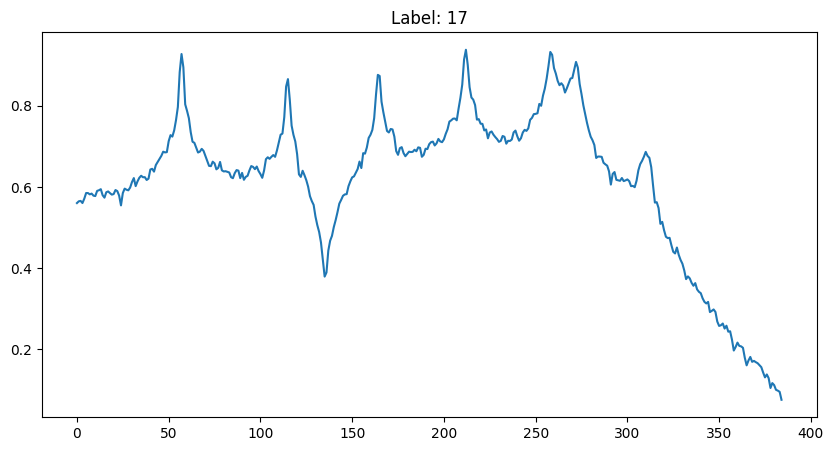

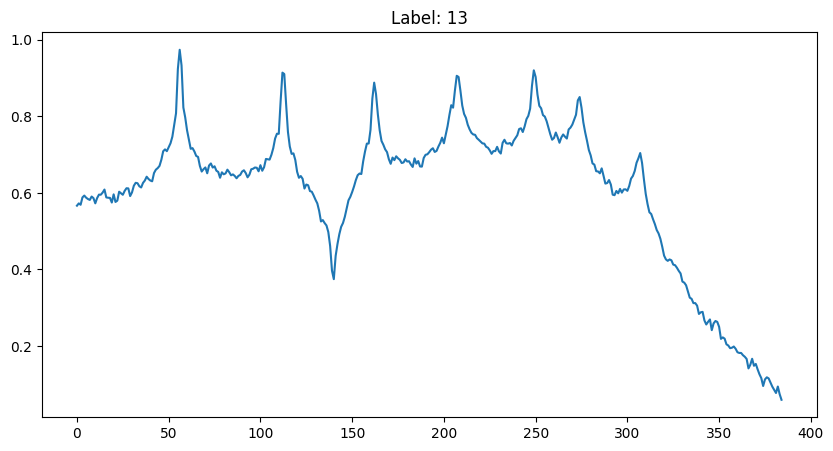

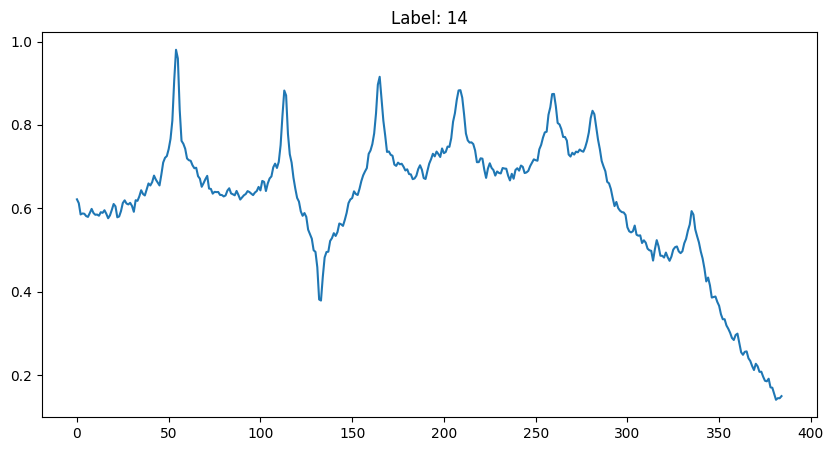

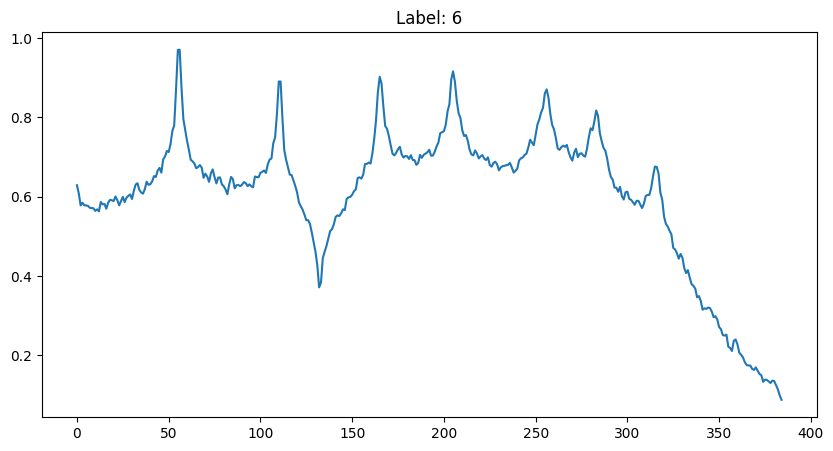

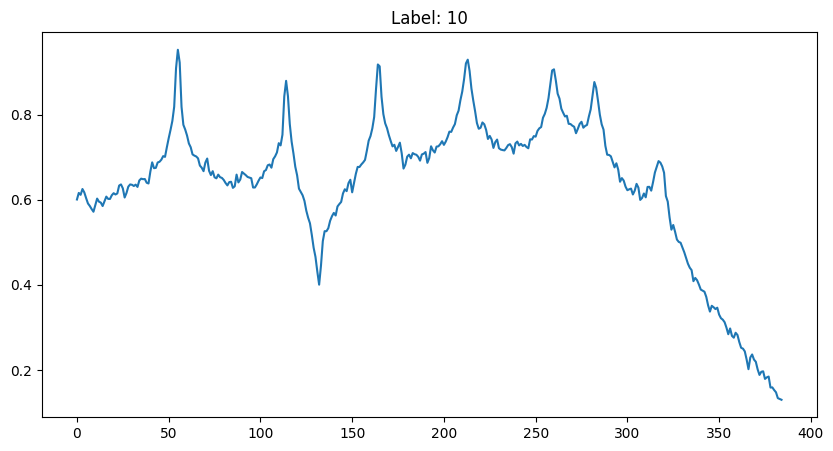

In [31]:
import matplotlib.pyplot as plt

# Fetch one batch of data
data, labels = next(iter(train_dl))

# We will plot first few samples in the batch
for i in range(5):
    plt.figure(figsize=(10, 5))
    plt.plot(data[i].numpy())
    plt.title(f"Label: {labels[i].item()}")
    plt.show()
